## **Dicoding Submission (Machine Learning for Beginners)**

### **Introduction**

Nama: Mellisa Damayanti

Username: mellisadmyn

Tentang: Pengembangan Model Klasifikasi Gambar Batu-Gunting-Kertas Menggunakan Algoritma CNN dengan TensorFlow

### **Import Libraries**

In [ ]:
!pip install tensorflow

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files

### **Download the dataset**
Dengan menggunakan perintah `wget`, dataset akan diunduh dari URL dan disimpan sebagai file ZIP di direktori sementara (`/tmp`). Selanjutnya, perintah `unzip` digunakan untuk mengekstrak isi ZIP ke dalam direktori `/dataset`.

Parameter `--no-check-certificate` digunakan untuk mengatasi isu sertifikat SSL saat download dengan `wget`. Parameter `-O` menentukan nama file output dan `-d` digunakan untuk menentukan direktori tujuan.

In [2]:
!wget --no-check-certificate \
    https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
    -O /tmp/rockpaperscissors.zip

!unzip "/tmp/rockpaperscissors.zip" -d "/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /dataset/rockpaperscissors/scissors/KNNsNhduqSfuqEK5.png  
  inflating: /dataset/__MACOSX/rockpaperscissors/scissors/._KNNsNhduqSfuqEK5.png  
  inflating: /dataset/rockpaperscissors/scissors/xAnfzBYnsnuru9Nf.png  
  inflating: /dataset/__MACOSX/rockpaperscissors/scissors/._xAnfzBYnsnuru9Nf.png  
  inflating: /dataset/rockpaperscissors/scissors/caj9PiWZ2BenuxXF.png  
  inflating: /dataset/__MACOSX/rockpaperscissors/scissors/._caj9PiWZ2BenuxXF.png  
  inflating: /dataset/rockpaperscissors/scissors/5CzwWCDnxKOJz5T0.png  
  inflating: /dataset/__MACOSX/rockpaperscissors/scissors/._5CzwWCDnxKOJz5T0.png  
  inflating: /dataset/rockpaperscissors/scissors/7dBQ0fOpCs03OmnR.png  
  inflating: /dataset/__MACOSX/rockpaperscissors/scissors/._7dBQ0fOpCs03OmnR.png  
  inflating: /dataset/rockpaperscissors/scissors/DXQaN15KphkE4i7z.png  
  inflating: /dataset/__MACOSX/rockpaperscissors/scissors/._DXQaN15KphkE4i7z.png  
  inflating: /datas

### **Dataset Exploration**

In [3]:
# mengecek isi directory yang telah diunduh (folder dataset)

print("Isi directory dataset:", os.listdir('/dataset'))
print("Isi directory rockpaperscissors:", os.listdir('/dataset/rockpaperscissors/rps-cv-images'))

Isi directory dataset: ['__MACOSX', 'rockpaperscissors']
Isi directory rockpaperscissors: ['paper', 'scissors', 'rock', 'README_rpc-cv-images.txt']


In [4]:
def check_dir(path_dir=None, sub_dir=None):
  total_all = 0

  for label in sub_dir:
    total_data = len(os.listdir(os.path.join(path_dir, label)))
    total_all += total_data
    print(f'Total {label}: {total_data}')

  print(f'Total keseluruhan: {total_all}')


  '''
  Tujuan: Mencetak total data untuk setiap label yang ditemukan dalam direktori dan total keseluruhannya.

  Parameters:
    path_dir (str): Path ke direktori yang akan diperiksa.
    sub_dir (list): Nama sub-direktori yang akan dicari dalam direktori.

  Returns:
    None (hanya mencetak informasi ke console)

  '''

In [5]:
# mengecek jumlah data dalam direktori berdasarkan label.

check_dir('/dataset/rockpaperscissors/rps-cv-images',['rock','paper','scissors'])

Total rock: 726
Total paper: 712
Total scissors: 750
Total keseluruhan: 2188


### **Dataset Composition**

*   Membagi dataset menjadi train set dan validation set menggunakan `validation_split` pada generator
*   Ukuran validation set adalah `40%` dari total dataset (`data training = 1314 sampel`, dan `data validasi = 874 sampel`)
*   Melakukan augmentasi gambar untuk meningkatkan generalisasi model selama proses training

In [6]:
# menginisiasi dan membuat direktori path
main_path = '/dataset/rockpaperscissors/rps-cv-images/'

# mendefinisikan dimensi image
img_height = 150
img_width = 150
input_size = (img_height, img_width)

# mengkonfigurasi data augmentation untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.4   # validation set 40%
)

# pembuatan generator untuk training set dan validation set
train_generator = train_datagen.flow_from_directory(
    main_path,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    main_path,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [7]:
# memetakan nama kelas ke indeks kelas

class_indices = train_generator.class_indices
print(class_indices)

{'paper': 0, 'rock': 1, 'scissors': 2}


In [8]:
def display_augmented_images(data_generator, num_samples_to_display=10):
  # konfigurasi untuk tata letak subplot
  num_rows= 2
  num_cols = int(num_samples_to_display/num_rows)

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
  for i in range(num_rows):
    for j in range(num_cols):
      # mengambil batch dari generator data
      batch = data_generator.next()

      # dari batch tersebut, akan mengekstrak gambar pertama (image) dan labelnya (label)
      image = batch[0][0]
      label = batch[1][0]

      # menggunakan metode .argmax() pada label untuk mengonversi format one-hot encoding ke indeks kelas asli.
      class_index = label.argmax()

      axes[i, j].imshow(image)
      axes[i, j].set_title(f"Class: {class_index}")
      axes[i, j].axis('off')

  plt.show()

  '''
  Tujuan:  Menampilkan gambar-gambar yang telah di-augmentasi dari generator data.

  Parameters:
    data_generator (keras.preprocessing.image.DirectoryIterator): Generator data yang menghasilkan batch gambar dan label.
    num_samples_to_display (int): Jumlah sampel gambar yang akan ditampilkan dalam satu plot (default=10).

  Returns:
    None (menampilkan plot gambar ke console)

  '''

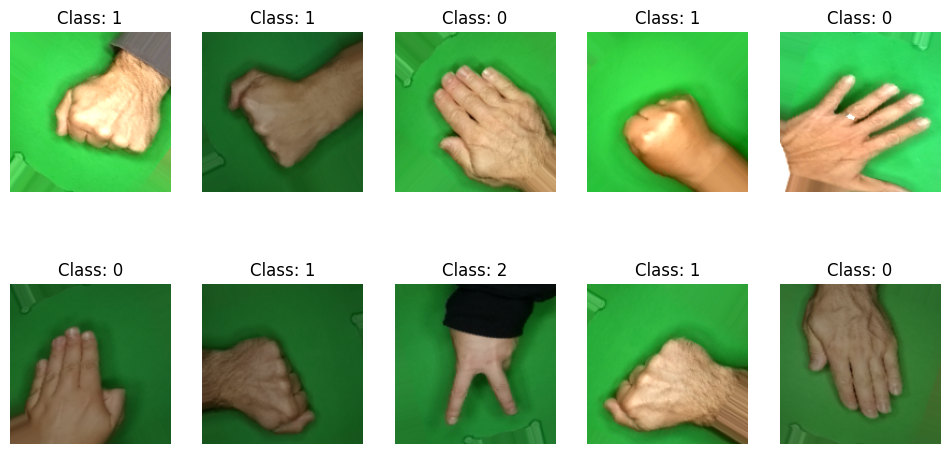

In [9]:
display_augmented_images(train_generator, num_samples_to_display=10)

### **Sequential Modeling**

Pada tahap ini, akan membuat model dengan mendefinisikan sebuah `Convolutional Neural Network` menggunakan `Keras`, dengan layers untuk feature extraction (convolutions, max pooling) dan classification (flatten, dropout, dense), dilatih dengan categorical cross-entropy untuk multi-class classification.

In [17]:
input_shape=(img_height,img_width,3)

model = Sequential([
  Conv2D(16, (3,3), activation='relu', input_shape= input_shape),
  MaxPooling2D(2, 2),
  Conv2D(32, (3,3), activation='relu'),
  MaxPooling2D(2,2),
  Conv2D(64, (3,3), activation='relu'),
  MaxPooling2D(2,2),
  Conv2D(128, (3,3), activation='relu'),
  MaxPooling2D(2,2),
  Flatten(),
  Dropout(0.5),
  Dense(512, activation='relu'),
  Dense(3, activation='softmax') # softmax klasifikasi multiclass, signoid klasifikasi biner
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 64)       

### **Model Training**

Tahap ini akan melatih `neural network model` yang telah dirancang untuk `50 epoch` menggunakan image data generators untuk train dan validation, lalu memeriksa apakah akurasi akhir melampaui 85%, dan mencetak hasilnya.

In [19]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
  train_generator,
  steps_per_epoch = 21, # total training images/batch size (32+32) = 1312/64
  epochs = 50,
  validation_data = validation_generator,
  validation_steps = 14,  # total validation images/batch_size = 876/64
  callbacks=[earlystop, checkpoint]
)


Epoch 1/50
21/21 [==============================] - 33s 2s/step - loss: 1.1004 - accuracy: 0.3661 - val_loss: 1.0665 - val_accuracy: 0.3415
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 26s 1s/step - loss: 1.0105 - accuracy: 0.4798 - val_loss: 0.9284 - val_accuracy: 0.5915
Epoch 3/50
21/21 [==============================] - 30s 1s/step - loss: 0.8413 - accuracy: 0.6220 - val_loss: 0.8067 - val_accuracy: 0.6362
Epoch 4/50
21/21 [==============================] - 29s 1s/step - loss: 0.8215 - accuracy: 0.6231 - val_loss: 0.8104 - val_accuracy: 0.6585
Epoch 5/50
21/21 [==============================] - 27s 1s/step - loss: 0.7458 - accuracy: 0.6885 - val_loss: 0.7461 - val_accuracy: 0.6339
Epoch 6/50
21/21 [==============================] - 29s 1s/step - loss: 0.6495 - accuracy: 0.7150 - val_loss: 0.6031 - val_accuracy: 0.7924
Epoch 7/50
21/21 [==============================] - 27s 1s/step - loss: 0.6472 - accuracy: 0.7604 - val_loss: 0.5882 - val_accuracy: 0.7969
Epoch 8/50
21/21 [==============================] - 31s 1s/step - loss: 0.5727 - accuracy: 0.7741 - val_loss: 0.4560 - val_accuracy: 0.8415
Epoch 9/50
21/21 [=============

In [20]:
# Mengekstrak nilai akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat dataframe
data = {
    'Epoch': range(1, len(acc) + 1),
    'Accuracy': acc,
    'Validation Accuracy': val_acc,
    'Loss': loss,
    'Validation Loss': val_loss
}

df = pd.DataFrame(data)

# Menampilkan dataframe
display(df)

,Epoch,Accuracy,Validation Accuracy,Loss,Validation Loss
0,1,0.366071,0.341518,1.100413,1.066463
1,2,0.479751,0.591518,1.010522,0.928373
2,3,0.622024,0.636161,0.841322,0.806661
3,4,0.623053,0.658482,0.821495,0.810359
4,5,0.688474,0.633929,0.745788,0.746074
5,6,0.714953,0.792411,0.649461,0.603129
6,7,0.760417,0.796875,0.647247,0.588210
7,8,0.774143,0.841518,0.572733,0.455985
8,9,0.818452,0.819196,0.479872,0.497178
9,10,0.822430,0.794643,0.450561,0.479214


In [21]:
# Mencetak nilai akurasi train dan validation
train_accuracy = acc[-1]
val_accuracy = val_acc[-1]

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

# Cek apakah akurasi model sudah di atas 85%
if train_accuracy >= 0.85:
    print("Model reached 85% accuracy.")
else:
    print("Model didn't reach 85% accuracy.")

Training Accuracy: 0.9211309552192688
Validation Accuracy: 0.9508928656578064
Model reached 85% accuracy.


### **Model Evaluation**

Tahap ini akan memvisualisasikan `training & validation loss` dan `accuracy` model yang telah dirancang, memplotkannya pada grafik dengan garis-garis yang berbeda untuk perbandingannya, sehingga membantu dalam evaluasi kinerja model.

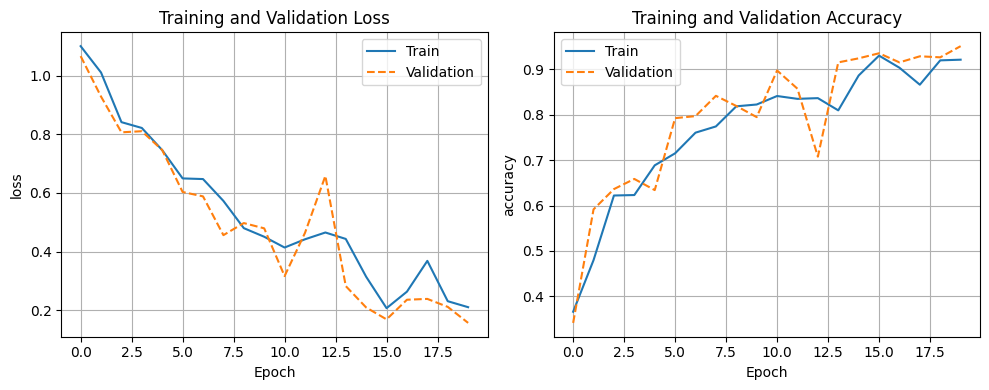

In [22]:
# asumsikan history adalah objek History dari metode fit dari model Keras
visualisasi_history = history.history

plt.figure(figsize=(10, 4))

def plot_history(visualisasi_history, ax, metric, title):
    ax.plot(visualisasi_history[metric])
    ax.plot(visualisasi_history['val_' + metric], linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend(['Train', 'Validation'])
    ax.grid(True)

ax1 = plt.subplot(1, 2, 1)
plot_history(visualisasi_history, ax1, 'loss', 'Training and Validation Loss')

ax2 = plt.subplot(1, 2, 2)
plot_history(visualisasi_history, ax2, 'accuracy', 'Training and Validation Accuracy')

plt.tight_layout()
plt.show()

### **Image Prediction**

Pada tahap ini, users dapat mengunggah gambar ke notebook Colab, yang kemudian diproses dan dimasukkan ke dalam neural network model untuk dilakukan klasifikasi. Model ini memprediksi apakah setiap gambar menggambarkan `batu`, `kertas`, atau `gunting`. Hasilnya ditampilkan secara visual dalam satu baris dengan prediksi yang dilabeli di atas setiap gambar.

Saving WhatsApp_Image_2023-11-05_at_10.05.21_63b70b3e-removebg-preview-removebg-preview.png to WhatsApp_Image_2023-11-05_at_10.05.21_63b70b3e-removebg-preview-removebg-preview (1).png
Saving download__1_-removebg-preview.png to download__1_-removebg-preview (1).png
Saving WhatsApp Image 2023-11-05 at 10.03.28_ad759090.jpg to WhatsApp Image 2023-11-05 at 10.03.28_ad759090 (1).jpg
1/1 [==============================] - 0s 27ms/step


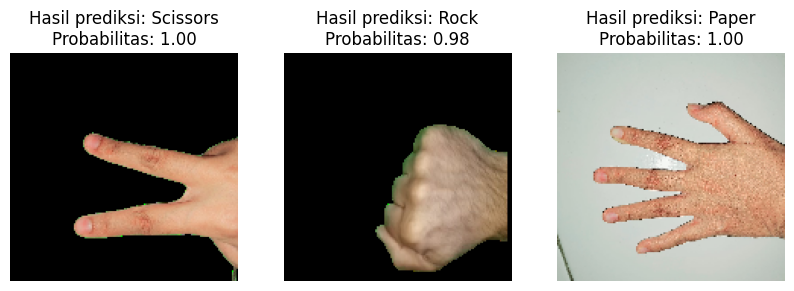

In [23]:
%matplotlib inline

# inisialisasi list untuk menyimpan gambar, prediksi, dan probabilitas
user_images = []
predictions = []
prediction_probabilities = []

# upload gambar
uploaded = files.upload()

# memproses setiap file gambar
for i, (image_path, _) in enumerate(uploaded.items()):
    path = image_path
    img = image.load_img(path, target_size=(150, 150))
    user_images.append(img)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # preprocessing gambar (normalisasi)
    x = np.vstack([x])

    # prediksi kelas dan probabilitas dari image tersebut
    prediction = model.predict(x, batch_size=10)
    predicted_class = np.argmax(prediction)
    prediction_probability = prediction[0][predicted_class]

    # append prediksi kelas dan probabilitas yang telah diprediksi ke list predictions
    if predicted_class == 0:
        predictions.append('Paper')
    elif predicted_class == 1:
        predictions.append('Rock')
    elif predicted_class == 2:
        predictions.append('Scissors')

    prediction_probabilities.append(prediction_probability)

# plot semua gambar dan hasil prediksi
plt.figure(figsize=(10, 5))
for i, (img, prediction, prediction_probability) in enumerate(zip(user_images, predictions, prediction_probabilities)):
    plt.subplot(1, len(user_images), i + 1)
    plt.imshow(img)
    plt.title(f'Hasil prediksi: {prediction}\nProbabilitas: {prediction_probability:.2f}')
    plt.axis('off')

plt.show()